# XGB Model - Hypertuning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import xgboost as xgb
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

In [2]:
##############################################################################
##########                DATABASE FUNCTIONS                     #############
##############################################################################
#### Read function to import data from the SQL to a pandas dataframe.
def readSQL(query):
    import pandas as pd
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    df = pd.read_sql_query(query, db)
    db.close()
    return(df)

#### Write a pandas dataframe into an SQL table. Use overwrite=True if you want to delete 
#### first a pre-existent table with the same name. Use append=True if you want to append
#### the data in the dataframe to a pre-existent table.
def writeSQL(df,tablename,overwrite=False, append=False):
    import pandas as pd
    import sqlite3 as sql
    db = sql.connect(DB_FILE)
    if (overwrite):
        action = "replace"
    elif (append):
        action = "append"
    else: 
        action = "fail"
    df.to_sql(tablename, db, if_exists=action)
    db.close()
def listTables():
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    cur = db.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
    res = cur.fetchall()
    cur.close()
    db.close()
    return(res)

In [3]:
import os
cwd = os.getcwd()
DB_FILE = "%s\Data\loans.db" % cwd

In [4]:
X_Train = readSQL('''SELECT * FROM X_train_scaled''')

In [5]:
Y_Train = readSQL('''SELECT * FROM Y_train''')

In [6]:
X_Train = X_Train.drop(["index"],axis=1)

In [7]:
Y_Train = Y_Train.drop(["index"],axis=1)

In [8]:
X_Dev = readSQL('''SELECT * FROM X_dev_scaled''')

In [9]:
X_Dev = X_Dev.drop(["index"],axis=1)

In [10]:
Y_Dev = readSQL('''SELECT * FROM Y_dev''')

In [11]:
Y_Dev = Y_Dev.drop(["index"],axis=1)

In [12]:
Y_Train = Y_Train.values.ravel()
Y_Dev = Y_Dev.values.ravel()

## Base XGBoost

In [22]:
# Transform data to a DMatrix object
dtrain = xgb.DMatrix(np.array(X_Train), label=Y_Train)
ddev = xgb.DMatrix(np.array(X_Dev), Y_Dev)

In [16]:
# Set the parameters for the xgboost
param = {'max_depth':5, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
#param['nthread'] = 10
param['eval_metric'] = 'auc'
# Train the model using the training sets
num_round = 10
mod_xgboost = xgb.train(param, dtrain, num_round)

In [30]:
filename= "%s\Models\XGB_base_model.sav" % cwd
pickle.dump(mod_xgboost, open(filename, 'wb'))

In [32]:
pred_train = mod_xgboost.predict(dtrain)

In [33]:
pred_dev = mod_xgboost.predict(ddev)

In [34]:
train_score = metrics.roc_auc_score(Y_Train, pred_train)

In [35]:
dev_score = metrics.roc_auc_score(Y_Dev, pred_dev)

In [36]:
print(train_score)
print(dev_score)

0.7079486709899623
0.6832650199171383


## Base XGB Classifier

In [87]:
param_dist = {'objective':'binary:logistic','n_jobs':2}
clf = xgb.XGBClassifier(**param_dist)
clf.mod=clf.fit(X_Train, Y_Train,
        eval_set=[(X_Train, Y_Train), (X_Dev, Y_Dev)],
        eval_metric='auc',
        verbose=False)
evals_result = clf.mod.evals_result()

In [88]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=2, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=2, nthread=None, objective='binary:logistic',
       random_state=1207, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [89]:
pred_train = evals_result['validation_0']['auc'][-1]
pred_dev = evals_result['validation_1']['auc'][-1]
print(pred_train)
print(pred_dev)


0.701423
0.690246


In [86]:
pred_train = clf.mod.predict_proba(X_Train)
pred_dev = clf.mod.predict_proba(X_Dev)

train_score = metrics.roc_auc_score(Y_Train, pred_train[:,1])
dev_score = metrics.roc_auc_score(Y_Dev, pred_dev[:,1])
print(train_score)
print(dev_score)

0.7014234721522628
0.6902463659005371


<b>Checking model fit for hyperparamters tuning

In [14]:
n_estimators = [100, 200, 300, 400, 500 , 1000]
learning_rate = [0.001, 0.01, 0.1, 0.2 , 0.3]
res = []
for n in n_estimators:
    for l in learning_rate:
        param_dist = {'objective':'binary:logistic','random_state':1207,'n_jobs':4}
        param_dist['n_estimators'] = n
        param_dist['learning_rate'] =l
        model = xgb.XGBClassifier(**param_dist)
        model = model.fit(X_Train, Y_Train)
        pred_train = model.predict_proba(X_Train)
        pred_dev = model.predict_proba(X_Dev)
        train_score = metrics.roc_auc_score(Y_Train, pred_train[:,1])
        dev_score = metrics.roc_auc_score(Y_Dev, pred_dev[:,1])
        res.append([n,l,train_score,dev_score])
        print("n_estimators: %s | learning_rate: %s | Train AUC: %s | Dev AUC: %s" % (n,l,train_score,dev_score))

n_estimators: 100 | learning_rate: 0.001 | Train AUC: 0.6467612175684008 | Dev AUC: 0.6450298208772438
n_estimators: 100 | learning_rate: 0.01 | Train AUC: 0.6573948755816859 | Dev AUC: 0.6539861925580803
n_estimators: 100 | learning_rate: 0.1 | Train AUC: 0.7014234721522628 | Dev AUC: 0.6902463659005371
n_estimators: 100 | learning_rate: 0.2 | Train AUC: 0.7103448336807247 | Dev AUC: 0.6955246128389586
n_estimators: 100 | learning_rate: 0.3 | Train AUC: 0.7163073163609537 | Dev AUC: 0.6973363692464791
n_estimators: 200 | learning_rate: 0.001 | Train AUC: 0.6507506578597431 | Dev AUC: 0.6482398151717839
n_estimators: 200 | learning_rate: 0.01 | Train AUC: 0.669168858908449 | Dev AUC: 0.6649840618197871
n_estimators: 200 | learning_rate: 0.1 | Train AUC: 0.7116683750597748 | Dev AUC: 0.6964889904578806
n_estimators: 200 | learning_rate: 0.2 | Train AUC: 0.7155025241054742 | Dev AUC: 0.6983791150851262
n_estimators: 200 | learning_rate: 0.3 | Train AUC: 0.7163073171749033 | Dev AUC: 0.69

In [15]:
res = pd.DataFrame(res, columns=['n_estimators','learning_rate','Train_auc_score','Dev_auc_score'])
res

,n_estimators,learning_rate,Train_auc_score,Dev_auc_score
0,100,0.001,0.646761,0.645030
1,100,0.010,0.657395,0.653986
2,100,0.100,0.701423,0.690246
3,100,0.200,0.710345,0.695525
4,100,0.300,0.716307,0.697336
5,200,0.001,0.650751,0.648240
6,200,0.010,0.669169,0.664984
7,200,0.100,0.711668,0.696489
8,200,0.200,0.715503,0.698379
9,200,0.300,0.716307,0.697336


In [17]:
res['AUC_Diff'] = res['Train_auc_score'] - res['Dev_auc_score']

In [19]:
res.sort_values(['Dev_auc_score','AUC_Diff'], ascending=[ 0 ,0])

,n_estimators,learning_rate,Train_auc_score,Dev_auc_score,AUC_Diff
12,300,0.100,0.717453,0.699235,0.018218
22,500,0.100,0.717453,0.699235,0.018218
17,400,0.100,0.717453,0.699235,0.018218
27,1000,0.100,0.717453,0.699235,0.018218
8,200,0.200,0.715503,0.698379,0.017123
13,300,0.200,0.715503,0.698379,0.017123
18,400,0.200,0.715503,0.698379,0.017123
23,500,0.200,0.715503,0.698379,0.017123
28,1000,0.200,0.715503,0.698379,0.017123
14,300,0.300,0.716307,0.697336,0.018971


We see the high dev auc_score with lower difference between train and dev with learning rate =0.1 and n_estimators=500

Tune max_depth and min_child_weight

In [13]:
max_depth = [3, 4, 5, 6, 8]
min_child_weight = [1, 2, 3, 4]
res = []
for n in max_depth:
    for l in min_child_weight:
        param_dist = {'objective':'binary:logistic','random_state':1207,'n_jobs':4,'learning_rate': 0.1,'n_estimators': 500 }
        param_dist['max_depth'] = n
        param_dist['min_child_weight'] =l
        model = xgb.XGBClassifier(**param_dist)
        model = model.fit(X_Train, Y_Train)
        pred_train = model.predict_proba(X_Train)
        pred_dev = model.predict_proba(X_Dev)
        train_score = metrics.roc_auc_score(Y_Train, pred_train[:,1])
        dev_score = metrics.roc_auc_score(Y_Dev, pred_dev[:,1])
        res.append([n,l,train_score,dev_score])
        print("max_depth: %s | min_child_weight: %s | Train AUC: %s | Dev AUC: %s" % (n,l,train_score,dev_score))

max_depth: 3 | min_child_weight: 1 | Train AUC: 0.7174528820447169 | Dev AUC: 0.6992345079194051
max_depth: 3 | min_child_weight: 2 | Train AUC: 0.7177001013274293 | Dev AUC: 0.6993639124092872
max_depth: 3 | min_child_weight: 3 | Train AUC: 0.7174950488662966 | Dev AUC: 0.6996113343760255
max_depth: 3 | min_child_weight: 4 | Train AUC: 0.7172194335682343 | Dev AUC: 0.6990800790261822
max_depth: 4 | min_child_weight: 1 | Train AUC: 0.7267712678370765 | Dev AUC: 0.7004477938974549
max_depth: 4 | min_child_weight: 2 | Train AUC: 0.7268135278558848 | Dev AUC: 0.7003491359018956
max_depth: 4 | min_child_weight: 3 | Train AUC: 0.726328119817036 | Dev AUC: 0.7012241688649854
max_depth: 4 | min_child_weight: 4 | Train AUC: 0.7257074359600701 | Dev AUC: 0.700979880795488
max_depth: 5 | min_child_weight: 1 | Train AUC: 0.7389585144547199 | Dev AUC: 0.7011342421254204
max_depth: 5 | min_child_weight: 2 | Train AUC: 0.7380276748602409 | Dev AUC: 0.7014295508735466
max_depth: 5 | min_child_weight:

In [14]:
res = pd.DataFrame(res, columns=['max_depth','min_child_weight','Train_auc_score','Dev_auc_score'])
res['AUC_Diff'] = res['Train_auc_score'] - res['Dev_auc_score']
res.sort_values(['Dev_auc_score','AUC_Diff'], ascending=[ 0 ,0])

,max_depth,min_child_weight,Train_auc_score,Dev_auc_score,AUC_Diff
13,6,2,0.751651,0.701818,0.049832
15,6,4,0.748643,0.701502,0.047141
9,5,2,0.738028,0.701430,0.036598
6,4,3,0.726328,0.701224,0.025104
8,5,1,0.738959,0.701134,0.037824
14,6,3,0.753358,0.701058,0.052300
7,4,4,0.725707,0.700980,0.024728
10,5,3,0.738057,0.700682,0.037375
4,4,1,0.726771,0.700448,0.026323
12,6,1,0.755068,0.700401,0.054667


We use max_depth =4 and min_child_weight=3

Tune subsample and colsample_bytree

In [16]:
subsample = [i/10.0 for i in range(5,9)]
subsample.append(1)
colsample_bytree = [i/10.0 for i in range(5,11)]
res = []
for n in subsample:
    for l in colsample_bytree:
        param_dist = {'objective':'binary:logistic','random_state':1207,'n_jobs':4,'learning_rate': 0.1,'n_estimators': 500 ,
                      'max_depth': 4, 'min_child_weight': 3}
        param_dist['subsample'] = n
        param_dist['colsample_bytree'] =l
        model = xgb.XGBClassifier(**param_dist)
        model = model.fit(X_Train, Y_Train)
        pred_train = model.predict_proba(X_Train)
        pred_dev = model.predict_proba(X_Dev)
        train_score = metrics.roc_auc_score(Y_Train, pred_train[:,1])
        dev_score = metrics.roc_auc_score(Y_Dev, pred_dev[:,1])
        res.append([n,l,train_score,dev_score])
        print("subsample: %s | colsample_bytree: %s | Train AUC: %s | Dev AUC: %s" % (n,l,train_score,dev_score))

subsample: 0.5 | colsample_bytree: 0.5 | Train AUC: 0.7418425437190841 | Dev AUC: 0.6993762764914362
subsample: 0.5 | colsample_bytree: 0.6 | Train AUC: 0.7420923146523832 | Dev AUC: 0.7016399117768948
subsample: 0.5 | colsample_bytree: 0.7 | Train AUC: 0.7435249697188652 | Dev AUC: 0.700730936056127
subsample: 0.5 | colsample_bytree: 0.8 | Train AUC: 0.7432021031816803 | Dev AUC: 0.7000406055375497
subsample: 0.5 | colsample_bytree: 0.9 | Train AUC: 0.7432290384016914 | Dev AUC: 0.7001630146282838
subsample: 0.5 | colsample_bytree: 1.0 | Train AUC: 0.7449551046346099 | Dev AUC: 0.7018234760398223
subsample: 0.6 | colsample_bytree: 0.5 | Train AUC: 0.7410973109229289 | Dev AUC: 0.7029748064805462
subsample: 0.6 | colsample_bytree: 0.6 | Train AUC: 0.7419285077032831 | Dev AUC: 0.7025240605870169
subsample: 0.6 | colsample_bytree: 0.7 | Train AUC: 0.7426612132454005 | Dev AUC: 0.7030194918014026
subsample: 0.6 | colsample_bytree: 0.8 | Train AUC: 0.743197072403416 | Dev AUC: 0.702373087

In [17]:
res = pd.DataFrame(res, columns=['subsample','colsample_bytree','Train_auc_score','Dev_auc_score'])
res['AUC_Diff'] = res['Train_auc_score'] - res['Dev_auc_score']
res.sort_values(['Dev_auc_score','AUC_Diff'], ascending=[ 0 ,0])

,subsample,colsample_bytree,Train_auc_score,Dev_auc_score,AUC_Diff
10,0.6,0.9,0.741396,0.703943,0.037453
22,0.8,0.9,0.737451,0.703644,0.033807
23,0.8,1.0,0.737335,0.703560,0.033774
12,0.7,0.5,0.741919,0.703455,0.038464
20,0.8,0.7,0.741341,0.703254,0.038087
14,0.7,0.7,0.742302,0.703192,0.039111
11,0.6,1.0,0.742018,0.703047,0.038971
8,0.6,0.7,0.742661,0.703019,0.039642
6,0.6,0.5,0.741097,0.702975,0.038123
26,1.0,0.7,0.733172,0.702863,0.030309


we use subsample =0.8 and colsample_bytree=1

tune gamma parameter

In [24]:
gamma = [0, 0.1, 0.2, 0.5, 1, 5, 10]
res = []
for n in gamma:
    param_dist = {'objective':'binary:logistic','random_state':1207,'n_jobs':4,'learning_rate': 0.1,'n_estimators': 500 ,
                  'max_depth': 4, 'min_child_weight': 3,'colsample_bytree': 1, 'subsample': 0.8 ,
                  'reg_lambda': 1 ,'reg_alpha': 0}
    param_dist['gamma'] = n
    model = xgb.XGBClassifier(**param_dist)
    model = model.fit(X_Train, Y_Train)
    pred_train = model.predict_proba(X_Train)
    pred_dev = model.predict_proba(X_Dev)
    train_score = metrics.roc_auc_score(Y_Train, pred_train[:,1])
    dev_score = metrics.roc_auc_score(Y_Dev, pred_dev[:,1])
    res.append([n,train_score,dev_score])
    print("gamma: %s | Train AUC: %s | Dev AUC: %s" % (n,train_score,dev_score))

gamma: 0 | Train AUC: 0.7373347642091874 | Dev AUC: 0.70356030995543
gamma: 0.1 | Train AUC: 0.7378661287375372 | Dev AUC: 0.7036145892635278
gamma: 0.2 | Train AUC: 0.7379012938833023 | Dev AUC: 0.7041575954287301
gamma: 0.5 | Train AUC: 0.7374418932433209 | Dev AUC: 0.7026681938742132
gamma: 1 | Train AUC: 0.7377922843814186 | Dev AUC: 0.7028797241422036
gamma: 5 | Train AUC: 0.7349401590923706 | Dev AUC: 0.7028547724993293
gamma: 10 | Train AUC: 0.7264385214983076 | Dev AUC: 0.7018289226804665


In [25]:
res = pd.DataFrame(res, columns=['gamma','Train_auc_score','Dev_auc_score'])
res['AUC_Diff'] = res['Train_auc_score'] - res['Dev_auc_score']
res.sort_values(['Dev_auc_score','AUC_Diff'], ascending=[ 0 ,0])

,gamma,Train_auc_score,Dev_auc_score,AUC_Diff
2,0.2,0.737901,0.704158,0.033744
1,0.1,0.737866,0.703615,0.034252
0,0.0,0.737335,0.703560,0.033774
4,1.0,0.737792,0.702880,0.034913
5,5.0,0.734940,0.702855,0.032085
3,0.5,0.737442,0.702668,0.034774
6,10.0,0.726439,0.701829,0.024610


we got good result with gamma = 0.2

Tune alpha - regularization L1 Lasso

In [18]:
reg_alpha = [1e-4, 1e-2, 0.1,0, 1, 5, 10]
res = []
for n in reg_alpha:
    param_dist = {'objective':'binary:logistic','random_state':1207,'n_jobs':4,'learning_rate': 0.1,'n_estimators': 500 ,
                  'max_depth': 4, 'min_child_weight': 3,'colsample_bytree': 1, 'subsample': 0.8}
    param_dist['reg_alpha'] = n
    model = xgb.XGBClassifier(**param_dist)
    model = model.fit(X_Train, Y_Train)
    pred_train = model.predict_proba(X_Train)
    pred_dev = model.predict_proba(X_Dev)
    train_score = metrics.roc_auc_score(Y_Train, pred_train[:,1])
    dev_score = metrics.roc_auc_score(Y_Dev, pred_dev[:,1])
    res.append([n,train_score,dev_score])
    print("reg_alpha: %s | Train AUC: %s | Dev AUC: %s" % (n,train_score,dev_score))

reg_alpha: 0.0001 | Train AUC: 0.7378486057864625 | Dev AUC: 0.7035861139351989
reg_alpha: 0.01 | Train AUC: 0.738218678307172 | Dev AUC: 0.7030123820643787
reg_alpha: 0.1 | Train AUC: 0.7365220116080597 | Dev AUC: 0.702627182956921
reg_alpha: 0 | Train AUC: 0.7373347642091874 | Dev AUC: 0.70356030995543
reg_alpha: 1 | Train AUC: 0.7404854157681141 | Dev AUC: 0.7035168771540345
reg_alpha: 5 | Train AUC: 0.7440620472780302 | Dev AUC: 0.7035801631684648
reg_alpha: 10 | Train AUC: 0.7409452491850955 | Dev AUC: 0.7035625447411906


In [20]:
res = pd.DataFrame(res, columns=['reg_alpha','Train_auc_score','Dev_auc_score'])
res['AUC_Diff'] = res['Train_auc_score'] - res['Dev_auc_score']
res.sort_values(['Dev_auc_score','AUC_Diff'], ascending=[ 0 ,0])

,reg_alpha,Train_auc_score,Dev_auc_score,AUC_Diff
0,0.0001,0.737849,0.703586,0.034262
5,5.0000,0.744062,0.703580,0.040482
6,10.0000,0.740945,0.703563,0.037383
3,0.0000,0.737335,0.703560,0.033774
4,1.0000,0.740485,0.703517,0.036969
1,0.0100,0.738219,0.703012,0.035206
2,0.1000,0.736522,0.702627,0.033895


We prefer to choose reg_alpha = 0 because it has the lowest auc difference

Tune lambda - regularization L2 Ridge

In [22]:
reg_lambda = [1e-4, 1e-2, 0.1, 1, 5, 10]
res = []
for n in reg_lambda:
    param_dist = {'objective':'binary:logistic','random_state':1207,'n_jobs':4,'learning_rate': 0.1,'n_estimators': 500 ,
                  'max_depth': 4, 'min_child_weight': 3,'colsample_bytree': 1, 'subsample': 0.8}
    param_dist['reg_lambda'] = n
    model = xgb.XGBClassifier(**param_dist)
    model = model.fit(X_Train, Y_Train)
    pred_train = model.predict_proba(X_Train)
    pred_dev = model.predict_proba(X_Dev)
    train_score = metrics.roc_auc_score(Y_Train, pred_train[:,1])
    dev_score = metrics.roc_auc_score(Y_Dev, pred_dev[:,1])
    res.append([n,train_score,dev_score])
    print("reg_lambda: %s | Train AUC: %s | Dev AUC: %s" % (n,train_score,dev_score))

reg_lambda: 0.0001 | Train AUC: 0.7372938104980846 | Dev AUC: 0.702714724192616
reg_lambda: 0.01 | Train AUC: 0.7378978664229511 | Dev AUC: 0.7034886512901626
reg_lambda: 0.1 | Train AUC: 0.7385175943775122 | Dev AUC: 0.7040308518930558
reg_lambda: 1 | Train AUC: 0.7373347642091874 | Dev AUC: 0.70356030995543
reg_lambda: 5 | Train AUC: 0.737424752767161 | Dev AUC: 0.7034380048082196
reg_lambda: 10 | Train AUC: 0.7384589330301714 | Dev AUC: 0.7036590303171036


In [23]:
res = pd.DataFrame(res, columns=['reg_lambda','Train_auc_score','Dev_auc_score'])
res['AUC_Diff'] = res['Train_auc_score'] - res['Dev_auc_score']
res.sort_values(['Dev_auc_score','AUC_Diff'], ascending=[ 0 ,0])

,reg_lambda,Train_auc_score,Dev_auc_score,AUC_Diff
2,0.1000,0.738518,0.704031,0.034487
5,10.0000,0.738459,0.703659,0.034800
3,1.0000,0.737335,0.703560,0.033774
1,0.0100,0.737898,0.703489,0.034409
4,5.0000,0.737425,0.703438,0.033987
0,0.0001,0.737294,0.702715,0.034579


We prefer to choose reg_lambda = 1 because it has the lowest auc difference

Combine the tuned parameters into final model

In [33]:
clf = xgb.XGBClassifier(silent=True, 
                      scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 1,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=500, 
                      max_depth=4, 
                      reg_lambda=1,
                      reg_alpha=0,
                     gamma=0.2,
                      min_child_weight=3,
                      random_state=1207,n_jobs=4)
clf.mod=clf.fit(X_Train, Y_Train,
        eval_set=[(X_Train, Y_Train), (X_Dev, Y_Dev)],
        eval_metric='auc',
        verbose=False)
evals_result = clf.mod.evals_result()

In [34]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=3, missing=None, n_estimators=500,
       n_jobs=4, nthread=None, objective='binary:logistic',
       random_state=1207, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [35]:
pred_train = clf.mod.predict_proba(X_Train)
pred_dev = clf.mod.predict_proba(X_Dev)

train_score = metrics.roc_auc_score(Y_Train, pred_train[:,1])
dev_score = metrics.roc_auc_score(Y_Dev, pred_dev[:,1])
print(train_score)
print(dev_score)

0.7379012938833023
0.7041575954287301


<b>Check for Calibration

In [36]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
from sklearn.metrics import brier_score_loss

In [37]:
fop, mpv = calibration_curve(Y_Dev, pred_dev[:,1], n_bins=10, normalize=False)

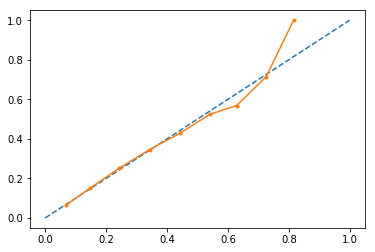

In [38]:
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

In [39]:
brier_score_loss(Y_Dev,  pred_dev[:,1])

0.1361149630695373

In [40]:
##Save the model
filename= "%s\Models\XGB_best_model.sav" % cwd
pickle.dump(clf.mod, open(filename, 'wb'))